# Sense and Move

In this notebook, let's put all of what we've learned together and see what happens to an initial probability distribution as a robot goes trough cycles of sensing then moving then sensing then moving, and so on! Recall that each time a robot senses (in this case a red or green color)it gains information about its environment, and everytime it moves, it loses some information due to motion uncertainty.


<img src='images/sense_move.png' width=50% height=50% />


First let's include our usual resource imports and display function.

In [2]:
import matplotlib.pyplot as plt
import numpy as np

A helper function for visualizing a distribution.

In [3]:
def display_map(grid, bar_width=1):
    if(len(grid) > 0):
        x_labels = range(len(grid))
        plt.bar(x_labels, height=grid, width=bar_width, color='b')
        plt.xlabel('Grid Cell')
        plt.ylabel('Probability')
        plt.ylim(0, 1) # range of 0-1 for probability values 
        plt.title('Probability of the robot being at each cell in the grid')
        plt.xticks(np.arange(min(x_labels), max(x_labels)+1, 1))
        plt.show()
    else:
        print('Grid is empty')


### QUIZ: Given the list motions=[1,1], compute the posterior distribution if the robot first senses red, then moves right one, then senses green, then moves right again, starting with a uniform prior distribution, `p`.

`motions=[1,1]` mean that the robot moves right one cell and then right again. You are given the initial variables and the complete `sense` and `move` function, below.

In [18]:
# INITIAL BELIEF: completely uncertain
p = [0.2, 0.2, 0.2, 0.2, 0.2]
# WORLD MAP: the color of each grid cell in the 1D world
world=['green', 'red', 'red', 'green', 'green']
# Measurement = Z, the sensor reading ('red' or 'green')
measurements = ['red', 'red'] # sequence of mesurements
pHit = 0.6 # the probability that it is sensing the color correctly
pMiss = 0.2 # the probability that it is sensing the wrong color

motions = [1,1] # sequence of movement steps to the right
# Movement accuracy
pExact = 0.8 # probability of moving correctly
pOvershoot = 0.1
pUndershoot = 0.1

def sense(p, Z):
    ''' Takes in a current probability distribution, p, and a sensor reading, Z.
        Returns a *normalized* distribution after the sensor measurement has been made, q.
        This should be accurate whether Z is 'red' or 'green'. '''
    q=[]
    # Loop through all grid cells
    for i in range(len(p)):
        # Check if the sensor reading is equal to the color of the grid cell
        # if so, hit = 1
        # if not, hit = 0
        # Basically, we apply pHit in all map cells
        # with the measurement value, pMiss in the rest
        hit = (Z == world[i])
        q.append(p[i] * (hit * pHit + (1-hit) * pMiss))
        
    # Normalize: divide all elements of q by the sum
    # because the complete distribution should add up to 1
    s = sum(q)
    for i in range(len(p)):
        q[i] = q[i] / s
    return q


def move(p, U):
    q=[]
    # Iterate through all values in p
    # The localization probability map is shifted
    # in the direction of motion and the accuracy
    # of the movement is also applied.
    # This is a CONVOLUTION of the previous p map
    for i in range(len(p)):
        # use the modulo operator to find the new location for a p value
        # this finds an index that is shifted by the correct amount
        index = (i-U) % len(p)
        #nextIndex = (index+1) % len(p)
        #prevIndex = (index-1) % len(p)
        nextIndex = (i-U+1) % len(p)
        prevIndex = (i-U-1) % len(p)
        s = pExact * p[index]
        s = s + pOvershoot  * p[nextIndex]
        s = s + pUndershoot * p[prevIndex]
        # append the correct, modified value of p to q
        q.append(s)
    return q

[0.12719897671622554, 0.09727327484104384, 0.20664721983869921, 0.35446515369992776, 0.21441537490410373]


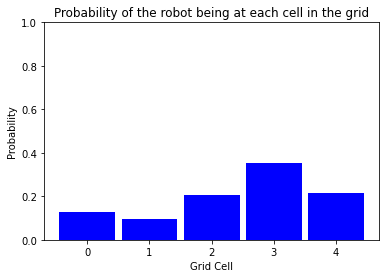

In [24]:
# Compute the posterior distribution if the robot first senses red, then moves 
# right one, then senses green, then moves right again, starting with a uniform prior distribution.
# This loop is in reality valid for any sequence of measurements and motions
for i in range(len(measurements)):
    p = sense(p, measurements[i])
    p = move(p, motions[i])
# Print/display that distribution
print(p)
display_map(p, bar_width=0.9)

### Clarification about Entropy

The video mentions that entropy will go down after the update step and that entropy will go up after the measurement step. 

In general, **entropy measures the amount of uncertainty**. Since the update step increases uncertainty, then entropy should increase. The measurement step decreases uncertainty, so entropy should decrease.

Let's look at our current example where the robot could be at five different positions. The maximum uncertainty occurs when all positions have equal probabilities  $[0.2, 0.2, 0.2, 0.2, 0.2]$ 

Following the formula $$\text{Entropy} = \Sigma  (-p \times log(p))$$we get $$-5 \times (.2)\times log(0.2) = 0.699$$

Taking a measurement should decrease uncertainty and thus decrease entropy. Let's say after taking a measurement, the probabilities become <span class="mathquill">[0.05, 0.05, 0.05, 0.8, 0.05]</span>. Now the entropy decreased to 0.338. Hence a measurement step should decrease entropy whereas an update step should increase entropy.